In [30]:
from ROOT import TFile,TTree,TCanvas,TH1F,gStyle,TLatex,gPad,TLegend,TLorentzVector,TH2F,TLine,TF1,TBox,RDataFrame,TPad,TF2
import ROOT
import numpy as np
import awkward as awk
import uproot
import pandas as pd
import matplotlib.pyplot as plot
from pandas import read_excel 
from copy import deepcopy
from ipywidgets import *
import logging, os 
logging.disable(logging.WARNING) 
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
print("tf.__version__", tf.__version__)


tf.__version__ 2.7.0


Above are necessary imports
Below we check to see if there is a file in the right place

Here we open the file in uproot and sort the trees into their respective objects

In [31]:
up4_file = uproot.open("../OutputFiles/AffinityFiles/Files_9_5/Exactfile3.root")
#up4_file = uproot.open("../OutputFiles/Slurm/Sept_5/Sept5_run1_0.root")
up4_z = up4_file["tree_z_h_bins"]
up4_x = up4_file["tree_x_bins"]
up4_Mh = up4_file["tree_Mh_bins"]

Now we can fill the arrays

In [32]:
#0 is z, 1 is x, 2 is mh
zarray = np.array([np.zeros(7)] * 6)
xarray = np.array([np.zeros(7)] * 6)
Mharray = np.array([np.zeros(7)] * 7)
xkinematics = np.array(["z_h", "Q2", "pT", "R0", "R1", "R2"])
zkinematics = np.array(["x", "Q2", "pT", "R0", "R1", "R2"])
Mhkinematics = np.array(["x", "z_h", "Q2", "pT", "R0", "R1", "R2"])

#These arrays each hold an array for each variable, meaning that the first bin of variables is in the first index of every kinematics array

#z
for i in range(zkinematics.size):
    zarray[i] = up4_z[zkinematics[i]].array(library = "np")
#x
for i in range(xkinematics.size):
    xarray[i] = up4_x[xkinematics[i]].array(library = "np")
#Mh
for i in range(Mhkinematics.size):
    Mharray[i] = up4_Mh[Mhkinematics[i]].array(library = "np")

In [33]:
print(xarray)

[[0.56724222 0.55862443 0.56817822 0.60564527 0.64761989 0.67456138
  0.66837982]
 [1.42747972 1.6985099  1.97695185 2.24486901 2.40710145 2.75570986
  3.57086249]
 [0.56137496 0.64186915 0.64599228 0.61977719 0.6705724  0.72095849
  0.82347713]
 [0.45018402 0.43630262 0.38713243 0.35249054 0.29619987 0.266704
  0.2017377 ]
 [0.20765401 0.33765777 0.33130866 0.5087022  0.61345784 0.71383017
  1.26495256]
 [0.29961975 0.26728658 0.202245   0.22267747 0.161021   0.14032862
  0.12661105]]


In [34]:
print(Mharray)

[[0.25478684 0.23408845 0.20905347 0.20474671 0.21932356 0.23463632
  0.23327994]
 [0.40276221 0.3648535  0.47503767 0.49172062 0.54004814 0.60080605
  0.64324098]
 [1.71548818 2.82380206 2.38090516 2.29068314 2.49626054 2.4923074
  2.56718114]
 [0.98397849 0.69100295 0.71514246 0.65818656 0.65069292 0.6819396
  0.6927941 ]
 [0.59957682 0.23656577 0.44474712 0.3556025  0.32039317 0.33189515
  0.29955438]
 [0.18725865 1.43457446 1.06933866 0.74478061 0.66850226 0.65607022
  0.53965958]
 [0.32701326 0.12767875 0.25222828 0.18205415 0.17972252 0.19998109
  0.1649233 ]]


If the first array is all 0s, that means that z, or x is being input as 0

In [35]:
# Need to transpose the array to get array of binned variables for each bin
xarray = np.transpose(xarray)
zarray = np.transpose(zarray)
Mharray = np.transpose(Mharray)

In [50]:
print(Mharray)

[[0.25478684 0.40276221 1.71548818 0.98397849 0.59957682 0.18725865
  0.32701326]
 [0.23408845 0.3648535  2.82380206 0.69100295 0.23656577 1.43457446
  0.12767875]
 [0.20905347 0.47503767 2.38090516 0.71514246 0.44474712 1.06933866
  0.25222828]
 [0.20474671 0.49172062 2.29068314 0.65818656 0.3556025  0.74478061
  0.18205415]
 [0.21932356 0.54004814 2.49626054 0.65069292 0.32039317 0.66850226
  0.17972252]
 [0.23463632 0.60080605 2.4923074  0.6819396  0.33189515 0.65607022
  0.19998109]
 [0.23327994 0.64324098 2.56718114 0.6927941  0.29955438 0.53965958
  0.1649233 ]]


Now to set up affinity calculation:

In [36]:
collinear_region_name = 'collinear'
current_region_name = 'current'
target_region_name = 'target'
TMD_region_name = 'TMD'
soft_region_name = 'soft'
collinear_lable_name = 'collinearaff'
target_lable_name = 'targetaff'
current_lable_name = 'currentaff'
TMD_lable_name = 'tmdaff'
soft_lable_name = 'softaff'

fname = '../../SIDIS-Affinity/expdata/eic.xlsx'
data=pd.read_excel(fname,index_col=0, engine='openpyxl')

data.pT.max()
data.keys()

test_features = deepcopy(data)
test_features = test_features.drop(columns=['W2', 'hadron', 'target'])

In [37]:
tmd_model_name = '../../SIDIS-Affinity/models/final_%s' % TMD_region_name
tmd_model = tf.keras.models.load_model(tmd_model_name)
target_model_name = '../../SIDIS-Affinity/models/final_%s' % target_region_name
target_model = tf.keras.models.load_model(target_model_name)
collinear_model_name = '../../SIDIS-Affinity/models/final_%s' % collinear_region_name
collinear_model = tf.keras.models.load_model(collinear_model_name)
current_model_name = '../../SIDIS-Affinity/models/final_%s' % current_region_name
current_model = tf.keras.models.load_model(current_model_name)
soft_model_name = '../../SIDIS-Affinity/models/final_%s' % soft_region_name
soft_model = tf.keras.models.load_model(soft_model_name)

Mhbins = np.linspace(0.3,1.3,7)
xbins = np.array([0.1,0.13,0.16,0.19,0.235,0.3,0.5])
zbins = np.array([0.35,0.43,0.49,0.55,0.62,0.7,0.83])

In [53]:
def calculator(array, region, binType, binnedVariable):
    if binType == "x":
        z = array[0]
        Q2 = array[1]
        pT = array[2]
        R0max = array[3]
        R1max = array[4]
        R2max = array[5]
        x = binnedVariable
    elif binType == "z":
        x = array[0]
        Q2 = array[1]
        pT = array[2]
        R0max = array[3]
        R1max = array[4]
        R2max = array[5]
        z = binnedVariable
    elif binType == "Mh":
        x = array[0]
        z = array[1]
        Q2 = array[2]
        pT = array[3]
        R0max = array[4]
        R1max = array[5]
        R2max = array[6]
        
    test_features = pd.DataFrame({'pT':pT,'Q2':Q2,'x':x,'z':z,'R0max':R0max,'R1max':R1max,'R2max':R2max},index=[0])

    if region == 'tmd':
        prediction = tmd_model.predict(test_features).flatten()
        
    elif region == 'target':
        prediction = target_model.predict(test_features).flatten()
        
    elif region == 'collinear':
        prediction = collinear_model.predict(test_features).flatten()

    elif region == 'soft':
        prediction = soft_model.predict(test_features).flatten()

    else:
        prediction = current_model.predict(test_features).flatten()

    return prediction[0] #returns affinity value

In [56]:
Mharray

array([[0.25478684, 0.40276221, 1.71548818, 0.98397849, 0.59957682,
        0.18725865, 0.32701326],
       [0.23408845, 0.3648535 , 2.82380206, 0.69100295, 0.23656577,
        1.43457446, 0.12767875],
       [0.20905347, 0.47503767, 2.38090516, 0.71514246, 0.44474712,
        1.06933866, 0.25222828],
       [0.20474671, 0.49172062, 2.29068314, 0.65818656, 0.3556025 ,
        0.74478061, 0.18205415],
       [0.21932356, 0.54004814, 2.49626054, 0.65069292, 0.32039317,
        0.66850226, 0.17972252],
       [0.23463632, 0.60080605, 2.4923074 , 0.6819396 , 0.33189515,
        0.65607022, 0.19998109],
       [0.23327994, 0.64324098, 2.56718114, 0.6927941 , 0.29955438,
        0.53965958, 0.1649233 ]])

In [54]:
xaffinity = np.zeros(7)
zaffinity = np.zeros(7)
Mhaffinity = np.zeros(7)
for i in range(len(zarray[i])):
    for j in range(len(zarray)):
        zaffinity[i] = calculator(zarray[j], "tmd", "z", zbins[i])
        xaffinity[i] = calculator(xarray[j], "tmd", "x", xbins[i])
        Mhaffinity[i] = calculator(Mharray[j], "tmd", "Mh", Mhbins[i])

In [55]:
print(zaffinity)
print(Mhaffinity)
print(xaffinity)

[5.64737602e-05 3.55333090e-04 1.16291642e-03 2.81143188e-03
 6.54846430e-03 1.52100921e-02 0.00000000e+00]
[0.01192987 0.01192987 0.01192987 0.01192987 0.01192987 0.01192987
 0.        ]
[0.01622874 0.01575327 0.01442191 0.01089427 0.00968483 0.00753245
 0.        ]


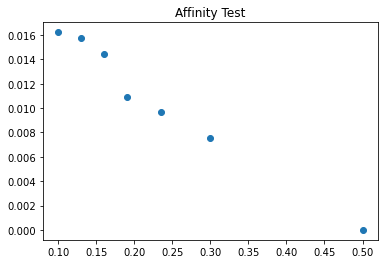

In [49]:


plot.title("Affinity Test")
plot.scatter(Mhbins, affinity)

In [30]:
zarray = [[] * 6] * 6
zarray[0] = up4_z["x"].array(library="np")
zarray[1] = up4_z["Q2"].array(library="np")
zarray[2] = up4_z["pT"].array(library="np")
zarray[3] = up4_z["R0"].array(library="np")
zarray[4] = up4_z["R1"].array(library="np")
zarray[5] = up4_z["R2"].array(library="np")



In [31]:
print(zarray)

[array([0., 0., 0., 0., 0., 0., 0.]), array([1.95887529, 1.99317774, 2.00376097, 2.02631579, 2.01606778,
       2.0179929 , 2.05828488]), array([0.0369166 , 0.07863555, 0.08900961, 0.1369863 , 0.1580485 ,
       0.23035986, 0.34578488]), array([0.0807192 , 0.07253142, 0.0635186 , 0.05587599, 0.03768624,
       0.02863659, 0.02136628]), array([0.        , 0.00179533, 0.        , 0.01189618, 0.06894537,
       0.15610745, 0.31424419]), array([0.02276205, 0.02190305, 0.02131216, 0.01766402, 0.01168566,
       0.00658895, 0.00436047])]


In [ ]:
xarray = up4_z["x"].array(library="np")
Q2array = up4_z["Q2"].array(library="np")
pTarray = up4_z["pT"].array(library="np")
R0array = up4_z["R0"].array(library="np")
R1array = up4_z["R1"].array(library="np")
R2array = up4_z["R2"].array(library="np")
print(xarray)

Binning from Greg:

In [11]:
Mhbins = np.linspace(0.3,1.3,7)
xbins = np.array([0.1,0.13,0.16,0.19,0.235,0.3,0.5])
zbins = np.array([0.35,0.43,0.49,0.55,0.62,0.7,0.83])
print(len(xbins))
print(len(zbins))

7
7


In [21]:
xlist = np.array([[-999.], [-999.], [-999.], [-999.], [-999.], [-999.], [-999.]])
xlist = np.append(xlist[1], 2)
xlist = np.append(xlist[0], 1)
xlist = np.append(xlist[1], 7)
print(xlist)

[1. 7.]


In [ ]:
xlist = np.array([[], [], [], [], [], [], []])
for i in range(len(xarray)):
    if xarray[i] <= xbins[1]:
        xlist.append
        